In [57]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import ttest_ind
import seaborn as sns
import torch
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from scikeras.wrappers import KerasRegressor
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split

In [58]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

In [3]:
df = pd.read_csv("train.csv")
df_test = pd.read_csv("test.csv")

In [4]:
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


## Thoughts

- Missing Values in Cabin is an issue because would be good to know location of cabin however this could be contained in class of ticket. Want to know if they were in the cabin of the end of the ship.
- Children and Women taken off the boat first?
- Parch is number of Parents or Children on the boat so would need to split by age to understand which is which
- Age - make definition of Child

## Exploratory Data Analysis

### Summary Statistics

In [5]:
df.isna().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

Will need to drop Cabin since there's too much missing data <br>
Need to check if missing Age data is Random

In [6]:
df.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


### Investigate Age Missing Data

In [7]:
df_miss_age = df[df.Age.isna()]
df_miss_age.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,177.000000,177.000000,177.000000,0.0,177.000000,177.000000,177.000000
mean,435.581921,0.293785,2.598870,NaN,0.564972,0.180791,22.158567
std,250.552901,0.456787,0.763216,NaN,1.626316,0.534145,31.874608
min,6.000000,0.000000,1.000000,NaN,0.000000,0.000000,0.000000
25%,230.000000,0.000000,3.000000,NaN,0.000000,0.000000,7.750000
50%,452.000000,0.000000,3.000000,NaN,0.000000,0.000000,8.050000
75%,634.000000,1.000000,3.000000,NaN,0.000000,0.000000,24.150000
max,889.000000,1.000000,3.000000,NaN,8.000000,2.000000,227.525000


In [8]:
df_age = df.dropna(subset=['Age'])
df_age.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,714.000000,714.000000,714.000000,714.000000,714.000000,714.000000,714.000000
mean,448.582633,0.406162,2.236695,29.699118,0.512605,0.431373,34.694514
std,259.119524,0.491460,0.838250,14.526497,0.929783,0.853289,52.918930
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,222.250000,0.000000,1.000000,20.125000,0.000000,0.000000,8.050000
50%,445.000000,0.000000,2.000000,28.000000,0.000000,0.000000,15.741700
75%,677.750000,1.000000,3.000000,38.000000,1.000000,1.000000,33.375000
max,891.000000,1.000000,3.000000,80.000000,5.000000,6.000000,512.329200


In [9]:
ttest_ind(df_age['Survived'], df_miss_age['Survived'])

Ttest_indResult(statistic=2.7606993230995345, pvalue=0.005886534840075564)

Don't want to completely discard NaN's of Age as it seems to be related to outcome <br>
Could generate different dummies for Age

## Feature Engineering

In [10]:
df["is_child"] = (df["Age"] >= 0) & (df["Age"] < 12)
df["is_older"] = df["Age"] >= 55
df["age_missing"] = df.Age.isna()
df["is_upper"] = df["Pclass"] == 1
df["is_middle"] = df["Pclass"] == 2
df["is_female"] = df["Sex"] == "female"

df_test["is_child"] = (df_test["Age"] >= 0) & (df_test["Age"] < 12)
df_test["is_older"] = df_test["Age"] >= 55
df_test["age_missing"] = df_test.Age.isna()
df_test["is_upper"] = df_test["Pclass"] == 1
df_test["is_middle"] = df_test["Pclass"] == 2
df_test["is_female"] = df_test["Sex"] == "female"

In [11]:
df["age_group"] = pd.cut(df['Age']
                         , bins=[float("NaN"), 0, 12, 24, 35, 45, 55, 100]
                         , labels=["Missing",'0-12', '12-24', '24-35','35-45','45-55','55+'])
df['age_group'] = df['age_group'].fillna("Missing")

df_test["age_group"] = pd.cut(df_test['Age']
                         , bins=[float("NaN"), 0, 12, 24, 35, 45, 55, 100]
                         , labels=["Missing",'0-12', '12-24', '24-35','35-45','45-55','55+'])
df_test['age_group'] = df_test['age_group'].fillna("Missing")

In [12]:
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,is_child,is_older,age_missing,is_upper,is_middle,is_female,age_group
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,False,False,False,False,False,False,12-24
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,False,False,False,True,False,True,35-45
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,False,False,False,False,False,True,24-35
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,False,False,False,True,False,True,24-35
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,False,False,False,False,False,False,24-35


In [13]:
df["Ticket"]

0             A/5 21171
1              PC 17599
2      STON/O2. 3101282
3                113803
4                373450
             ...       
886              211536
887              112053
888          W./C. 6607
889              111369
890              370376
Name: Ticket, Length: 891, dtype: object

## Plots

<AxesSubplot:xlabel='Survived', ylabel='count'>

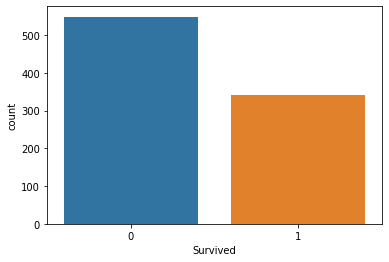

In [14]:
sns.countplot(x=df.Survived)

Need to scale up the 1s so don't get overshadowed by 0s

Text(60, 160, '$\\mu=19, \\sigma=15$')

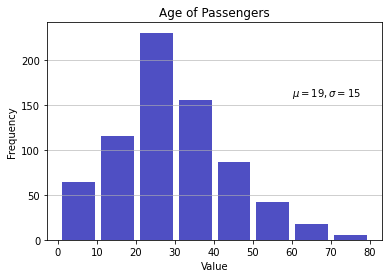

In [15]:
plt.hist(df.Age, color='#0504aa',
                            alpha=0.7, rwidth=0.85, bins=8)
plt.grid(axis='y', alpha=0.75)
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.title('Age of Passengers')
plt.text(60, 160, r'$\mu=19, \sigma=15$')

<AxesSubplot:xlabel='Pclass', ylabel='count'>

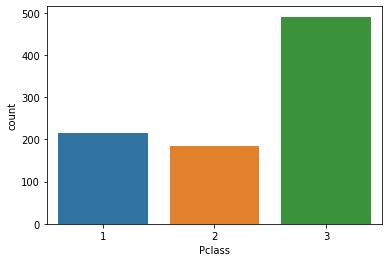

In [16]:
sns.countplot(x=df.Pclass)

Text(0.5, 1.0, 'Fare')

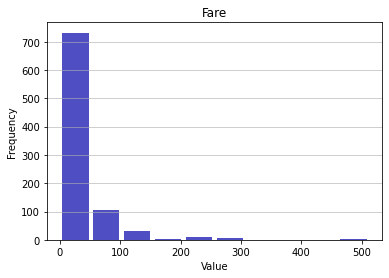

In [17]:
plt.hist(df.Fare, color='#0504aa',
                            alpha=0.7, rwidth=0.85, bins=10)
plt.grid(axis='y', alpha=0.75)
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.title('Fare')

<AxesSubplot:xlabel='SibSp', ylabel='count'>

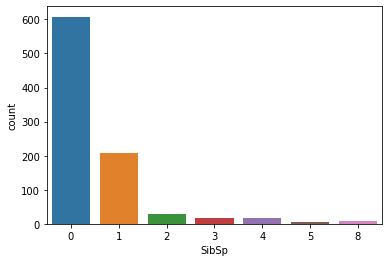

In [18]:
sns.countplot(x=df.SibSp)

<AxesSubplot:xlabel='Parch', ylabel='count'>

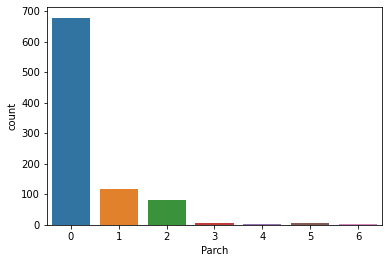

In [19]:
sns.countplot(x=df.Parch)

<AxesSubplot:xlabel='Age', ylabel='Survived'>

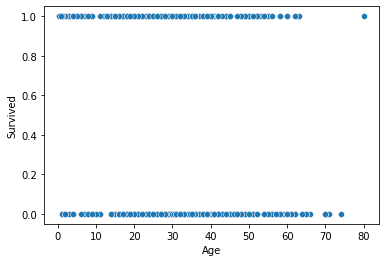

In [20]:
sns.scatterplot(x=df.Age, y=df.Survived)

In [21]:
df.upper = df[df["Pclass"] == 1]
df.upper.describe()

/var/folders/ws/0c53dsms5pl26qt7mb2sc6bw0000gn/T/ipykernel_49896/374134585.py:1: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  df.upper = df[df["Pclass"] == 1]


,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,216.000000,216.000000,216.0,186.000000,216.000000,216.000000,216.000000
mean,461.597222,0.629630,1.0,38.233441,0.416667,0.356481,84.154687
std,246.737616,0.484026,0.0,14.802856,0.611898,0.693997,78.380373
min,2.000000,0.000000,1.0,0.920000,0.000000,0.000000,0.000000
25%,270.750000,0.000000,1.0,27.000000,0.000000,0.000000,30.923950
50%,472.000000,1.000000,1.0,37.000000,0.000000,0.000000,60.287500
75%,670.500000,1.000000,1.0,49.000000,1.000000,0.000000,93.500000
max,890.000000,1.000000,1.0,80.000000,3.000000,4.000000,512.329200


In [22]:
df.middle = df[df["Pclass"] == 2]
df.middle.describe()

/var/folders/ws/0c53dsms5pl26qt7mb2sc6bw0000gn/T/ipykernel_49896/8920156.py:1: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  df.middle = df[df["Pclass"] == 2]


,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,184.000000,184.000000,184.0,173.000000,184.000000,184.000000,184.000000
mean,445.956522,0.472826,2.0,29.877630,0.402174,0.380435,20.662183
std,250.852161,0.500623,0.0,14.001077,0.601633,0.690963,13.417399
min,10.000000,0.000000,2.0,0.670000,0.000000,0.000000,0.000000
25%,234.500000,0.000000,2.0,23.000000,0.000000,0.000000,13.000000
50%,435.500000,0.000000,2.0,29.000000,0.000000,0.000000,14.250000
75%,668.000000,1.000000,2.0,36.000000,1.000000,1.000000,26.000000
max,887.000000,1.000000,2.0,70.000000,3.000000,3.000000,73.500000


In [23]:
df.econ = df[df["Pclass"] == 3]
df.econ.describe()

/var/folders/ws/0c53dsms5pl26qt7mb2sc6bw0000gn/T/ipykernel_49896/1998348813.py:1: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  df.econ = df[df["Pclass"] == 3]


,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,491.000000,491.000000,491.0,355.000000,491.000000,491.000000,491.000000
mean,439.154786,0.242363,3.0,25.140620,0.615071,0.393075,13.675550
std,264.441453,0.428949,0.0,12.495398,1.374883,0.888861,11.778142
min,1.000000,0.000000,3.0,0.420000,0.000000,0.000000,0.000000
25%,200.000000,0.000000,3.0,18.000000,0.000000,0.000000,7.750000
50%,432.000000,0.000000,3.0,24.000000,0.000000,0.000000,8.050000
75%,666.500000,0.000000,3.0,32.000000,1.000000,0.000000,15.500000
max,891.000000,1.000000,3.0,74.000000,8.000000,6.000000,69.550000


In [24]:
df["is_child"] = (df["Age"] >= 0) & (df["Age"] < 12)

In [25]:
df_child = df[df["is_child"] ==1]
df_child.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,68.000000,68.000000,68.000000,68.000000,68.000000,68.000000,68.000000
mean,436.941176,0.573529,2.632353,4.664265,1.882353,1.426471,31.834803
std,278.794788,0.498241,0.596117,3.297692,1.643889,0.554928,26.504422
min,8.000000,0.000000,1.000000,0.420000,0.000000,0.000000,8.516700
25%,183.750000,0.000000,2.000000,2.000000,0.750000,1.000000,19.140600
50%,433.000000,1.000000,3.000000,4.000000,1.000000,1.000000,27.825000
75%,723.750000,1.000000,3.000000,8.000000,4.000000,2.000000,31.790625
max,870.000000,1.000000,3.000000,11.000000,5.000000,2.000000,151.550000


In [26]:
df_adult = df[df["is_child"] == 0]
df_adult.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,823.000000,823.000000,823.000000,646.000000,823.000000,823.000000,823.000000
mean,446.748481,0.368165,2.281896,32.334365,0.410693,0.295261,32.234730
std,255.670177,0.482600,0.847639,12.613717,0.964823,0.761970,51.151251
min,1.000000,0.000000,1.000000,12.000000,0.000000,0.000000,0.000000
25%,227.500000,0.000000,1.000000,22.000000,0.000000,0.000000,7.895800
50%,447.000000,0.000000,3.000000,30.000000,0.000000,0.000000,13.000000
75%,666.500000,1.000000,3.000000,40.000000,1.000000,0.000000,30.500000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [27]:
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,is_child,is_older,age_missing,is_upper,is_middle,is_female,age_group
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,False,False,False,False,False,False,12-24
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,False,False,False,True,False,True,35-45
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,False,False,False,False,False,True,24-35
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,False,False,False,True,False,True,24-35
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,False,False,False,False,False,False,24-35


## Modelling

### Variables for Variable Selecting Models

In [45]:
select = ["Pclass", "is_female", "Age", "SibSp", "Parch"
         , "Fare", "is_child", "age_missing", "is_upper"
         , "is_middle", "is_older"]
X_train_sel = df[select]
y_train_sel = df["Survived"]

In [46]:
X_train_sel.head()

,Pclass,is_female,Age,SibSp,Parch,Fare,is_child,age_missing,is_upper,is_middle,is_older
0,3,False,22.0,1,0,7.2500,False,False,False,False,False
1,1,True,38.0,1,0,71.2833,False,False,True,False,False
2,3,True,26.0,0,0,7.9250,False,False,False,False,False
3,1,True,35.0,1,0,53.1000,False,False,True,False,False
4,3,False,35.0,0,0,8.0500,False,False,False,False,False


### Variables for Other Models

In [66]:
other = ["is_female", "SibSp", "Parch"
         , "is_child", "age_missing", "is_upper"
         , "is_middle", "is_older"]
X_train_other = df[other]

y_train_other = df["Survived"]

X_test_other = df_test[other]

In [30]:
X_test_other.head()

,is_female,SibSp,Parch,is_child,age_missing,is_upper,is_middle,is_older
0,False,0,0,False,False,False,False,False
1,True,1,0,False,False,False,False,False
2,False,0,0,False,False,False,True,True
3,False,0,0,False,False,False,False,False
4,True,1,1,False,False,False,False,False


In [31]:
X_test_other.isna().sum()

is_female      0
SibSp          0
Parch          0
is_child       0
age_missing    0
is_upper       0
is_middle      0
is_older       0
dtype: int64

In [70]:
X_train_other.dtypes

is_female       bool
SibSp          int64
Parch          int64
is_child        bool
age_missing     bool
is_upper        bool
is_middle       bool
is_older        bool
dtype: object

## Logistic Regression

Notes for improvement:
- Go through other variables and clean the dataset to get maximum variables entered into the train set / check for missing values
- Grid Search for optimising hyperparameters
- Visualisation of ROC AUC? Research what this means
- Visualisation of recall and all that stuff - research what this means?
- Standardisation of variables - is this necessary for better performance?
- Visualisation of most important variables from model fit
- Addition of some form of boosting?
- Increased feature engineering
- Class imbalance correction
- Interactions

In [94]:
numeric_features = X_train_other.columns
numeric_transformer = Pipeline(steps=[('poly',PolynomialFeatures(degree = 1))])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features)])

smt = SMOTE(random_state=42)

lor = LogisticRegression(penalty = 'none', max_iter = 10000)

logisticRegr = Pipeline([('preprocessor', preprocessor),
                ('lor',lor)])

In [95]:
logisticRegr.fit(X_train_other, y_train_other)
predictions = logisticRegr.predict(X_test_other)

In [96]:
predict_vals = zip(df_test["PassengerId"], predictions)
df_predict = pd.DataFrame(predict_vals, columns=['PassengerId','Survived'])
df_predict.to_csv('log_reg_pipeline_kaggle.csv',index=False)

## K-Nearest Neighbours

In [34]:
from sklearn.neighbors import KNeighborsClassifier

train_test_vals = []
n_max = 10

for i in range(n_max):
    neigh = KNeighborsClassifier(n_neighbors = i+1)
    neigh.fit(X_train_other, y_train_other)
    train_test_vals.append(np.sum(abs(neigh.predict(X_train_other) - y_train_other)) / len(y_train_other))

/Users/alexanderwade-smith/miniforge3/envs/.venv/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:237: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
/Users/alexanderwade-smith/miniforge3/envs/.venv/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:237: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be e

In [35]:
train_test_vals

[0.1728395061728395,
 0.19865319865319866,
 0.15600448933782268,
 0.16835016835016836,
 0.15937149270482603,
 0.1728395061728395,
 0.16722783389450055,
 0.16610549943883277,
 0.1638608305274972,
 0.16049382716049382]

In [36]:
neigh = KNeighborsClassifier(n_neighbors = 3)
neigh.fit(X_train_other, y_train_other)
knn_predict = neigh.predict(X_test_other)

/Users/alexanderwade-smith/miniforge3/envs/.venv/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:237: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)


In [37]:
predict_vals = zip(df_test["PassengerId"], knn_predict)
df_predict = pd.DataFrame(predict_vals, columns=['PassengerId','Survived'])
df_predict.to_csv('knn_kaggle.csv',index=False)

## Decision Tree

## Random Forest

Notes for improvement:
- Go through other variables and clean the dataset to get maximum variables entered into the train set / check for missing values
- Grid Search for optimising hyperparameters
- Visualisation of ROC AUC? Research what this means
- Visualisation of recall and all that stuff - research what this means?
- Standardisation of variables - is this necessary for better performance?
- Visualisation of most important variables from model fit
- Addition of some form of boosting?
- Increased feature engineering
- Class imbalance correction

In [53]:
clf = RandomForestClassifier(max_depth=10
                             , random_state=0
                             , min_samples_split = 10
                             , max_features="sqrt"
                             , bootstrap = True)
clf.fit(X_train_other, y_train_other)
clf_predict = clf.predict(X_test_other)

In [54]:
predict_vals = zip(df_test["PassengerId"], clf_predict)
df_predict = pd.DataFrame(predict_vals, columns=['PassengerId','Survived'])
df_predict.to_csv('clf_kaggle.csv',index=False)

## AdaBoost

## XGBoost

## SVMs

## Neural Network

In [8]:
# Define Sequential model with 3 layers
model = keras.Sequential(
    [
        layers.Dense(3, activation="relu", name="layer1"),
        layers.Dense(2, activation="relu", name="layer2"),
        layers.Dense(1, name="layer3"),
    ]
)
# Call model on a test input
x = tf.ones((3, 3))
y = model(x)

print(y)

tf.Tensor(
[[-0.8350242]
 [-0.8350242]
 [-0.8350242]], shape=(3, 1), dtype=float32)


In [118]:
X_train_array = X_train_other.values
X_train_array = X_train_array.astype(int)

X_test_array = X_test_other.values
X_test_array = X_test_array.astype(int)

y_train_tensor = y_train_other.values

In [98]:
print(y_train_tensor)

[0 1 1 1 0 0 0 0 1 1 1 1 0 0 0 1 0 1 0 1 0 1 1 1 0 1 0 0 1 0 0 1 1 0 0 0 1
 0 0 1 0 0 0 1 1 0 0 1 0 0 0 0 1 1 0 1 1 0 1 0 0 1 0 0 0 1 1 0 1 0 0 0 0 0
 1 0 0 0 1 1 0 1 1 0 1 1 0 0 1 0 0 0 0 0 0 0 0 1 1 0 0 0 0 0 0 0 1 1 0 1 0
 0 0 0 0 0 0 0 0 0 0 0 0 1 0 1 0 1 1 0 0 0 0 1 0 0 1 0 0 0 0 1 1 0 0 0 1 0
 0 0 0 1 0 0 0 0 1 0 0 0 0 1 0 0 0 1 1 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 1 1
 0 1 1 0 0 1 0 1 1 1 1 0 0 1 0 0 0 0 0 1 0 0 1 1 1 0 1 0 0 0 1 1 0 1 0 1 0
 0 0 1 0 1 0 0 0 1 0 0 1 0 0 0 1 0 0 0 1 0 0 0 0 0 1 1 0 0 0 0 0 0 1 1 1 1
 1 0 1 0 0 0 0 0 1 1 1 0 1 1 0 1 1 0 0 0 1 0 0 0 1 0 0 1 0 1 1 1 1 0 0 0 0
 0 0 1 1 1 1 0 1 0 1 1 1 0 1 1 1 0 0 0 1 1 0 1 1 0 0 1 1 0 1 0 1 1 1 1 0 0
 0 1 0 0 1 1 0 1 1 0 0 0 1 1 1 1 0 0 0 0 0 0 0 1 0 1 1 0 0 0 0 0 0 1 1 1 1
 1 0 0 0 0 1 1 0 0 0 1 1 0 1 0 0 0 1 0 1 1 1 0 1 1 0 0 0 0 1 1 0 0 0 0 0 0
 1 0 0 0 0 1 0 1 0 1 1 0 0 0 0 0 0 0 0 1 1 0 1 1 1 1 0 0 1 0 1 0 0 1 0 0 1
 1 1 1 1 1 1 0 0 0 1 0 1 0 1 1 0 1 0 0 0 0 0 0 0 0 1 0 0 1 1 0 0 0 0 0 1 0
 0 0 1 1 0 1 0 0 1 0 0 0 

In [167]:
# define base model
# create model
model = Sequential()
model.add(Dense(8, input_shape=(8,), kernel_initializer='glorot_normal', activation='sigmoid'))
model.add(Dense(4, kernel_initializer='glorot_normal', activation='relu'))
model.add(Dense(6, kernel_initializer='glorot_normal', activation='relu'))
model.add(Dense(1, activation='sigmoid'))
# Compile model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [168]:
model.fit(X_train_array, y_train_tensor, epochs=150, batch_size=10, verbose=0)

2022-09-07 19:21:10.662310: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


In [169]:
# make class predictions with the model
nn_predict = (model.predict(X_test_array) > 0.5).astype(int)

14/14 [==============================] - 0s 3ms/step


2022-09-07 19:22:24.500390: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


In [170]:
nn_predict = np.squeeze(nn_predict.reshape(1,-1))

In [172]:
predict_vals = zip(df_test["PassengerId"], nn_predict)
df_predict = pd.DataFrame(predict_vals, columns=['PassengerId','Survived'])
# df_predict.head(30)
df_predict.to_csv('neural_extra_layer_improv.csv',index=False)

In [116]:
# summarize the first 5 cases
for i in range(20):
    print('%s => %d (expected %d)' % (X_train_array[i].tolist(), predictions[i], y_train_tensor[i]))

[0, 1, 0, 0, 0, 0, 0, 0] => 0 (expected 0)
[1, 1, 0, 0, 0, 1, 0, 0] => 1 (expected 1)
[1, 0, 0, 0, 0, 0, 0, 0] => 1 (expected 1)
[1, 1, 0, 0, 0, 1, 0, 0] => 1 (expected 1)
[0, 0, 0, 0, 0, 0, 0, 0] => 0 (expected 0)
[0, 0, 0, 0, 1, 0, 0, 0] => 0 (expected 0)
[0, 0, 0, 0, 0, 1, 0, 0] => 0 (expected 0)
[0, 3, 1, 1, 0, 0, 0, 0] => 0 (expected 0)
[1, 0, 2, 0, 0, 0, 0, 0] => 0 (expected 1)
[1, 1, 0, 0, 0, 0, 1, 0] => 1 (expected 1)
[1, 1, 1, 1, 0, 0, 0, 0] => 1 (expected 1)
[1, 0, 0, 0, 0, 1, 0, 1] => 1 (expected 1)
[0, 0, 0, 0, 0, 0, 0, 0] => 0 (expected 0)
[0, 1, 5, 0, 0, 0, 0, 0] => 0 (expected 0)
[1, 0, 0, 0, 0, 0, 0, 0] => 1 (expected 0)
[1, 0, 0, 0, 0, 0, 1, 1] => 1 (expected 1)
[0, 4, 1, 1, 0, 0, 0, 0] => 0 (expected 0)
[0, 0, 0, 0, 1, 0, 1, 0] => 0 (expected 1)
[1, 1, 0, 0, 0, 0, 0, 0] => 0 (expected 0)
[1, 0, 0, 0, 1, 0, 0, 0] => 1 (expected 1)


In [76]:
y_train_tensor

<tf.Tensor: shape=(891,), dtype=int64, numpy=
array([0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1,
       1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1,
       1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1,
       1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0,
       1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0,
       0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0,
       0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0,
       1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0,
       1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1,
       0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0,
       0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0,
     

In [52]:
X_train_other.head()

,is_female,SibSp,Parch,is_child,age_missing,is_upper,is_middle,is_older
0,False,1,0,False,False,False,False,False
1,True,1,0,False,False,True,False,False
2,True,0,0,False,False,False,False,False
3,True,1,0,False,False,True,False,False
4,False,0,0,False,False,False,False,False


## Generative Adversarial Network